In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib.colors import ListedColormap

IS_DARK = False
theme, cs = rp.mpl_setup(IS_DARK)

In [3]:
df = pd.read_feather('logs/12345.feather')
df.head()

,comp_ind,e_form,group_num,volume_ratio,lattice_type,wyckoff_letters,total_dof,i,comp,group_symbol
0,0,-5.328977,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
1,1,-5.155964,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
2,2,-5.348216,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
3,3,-5.455560,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
4,4,-5.431657,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc


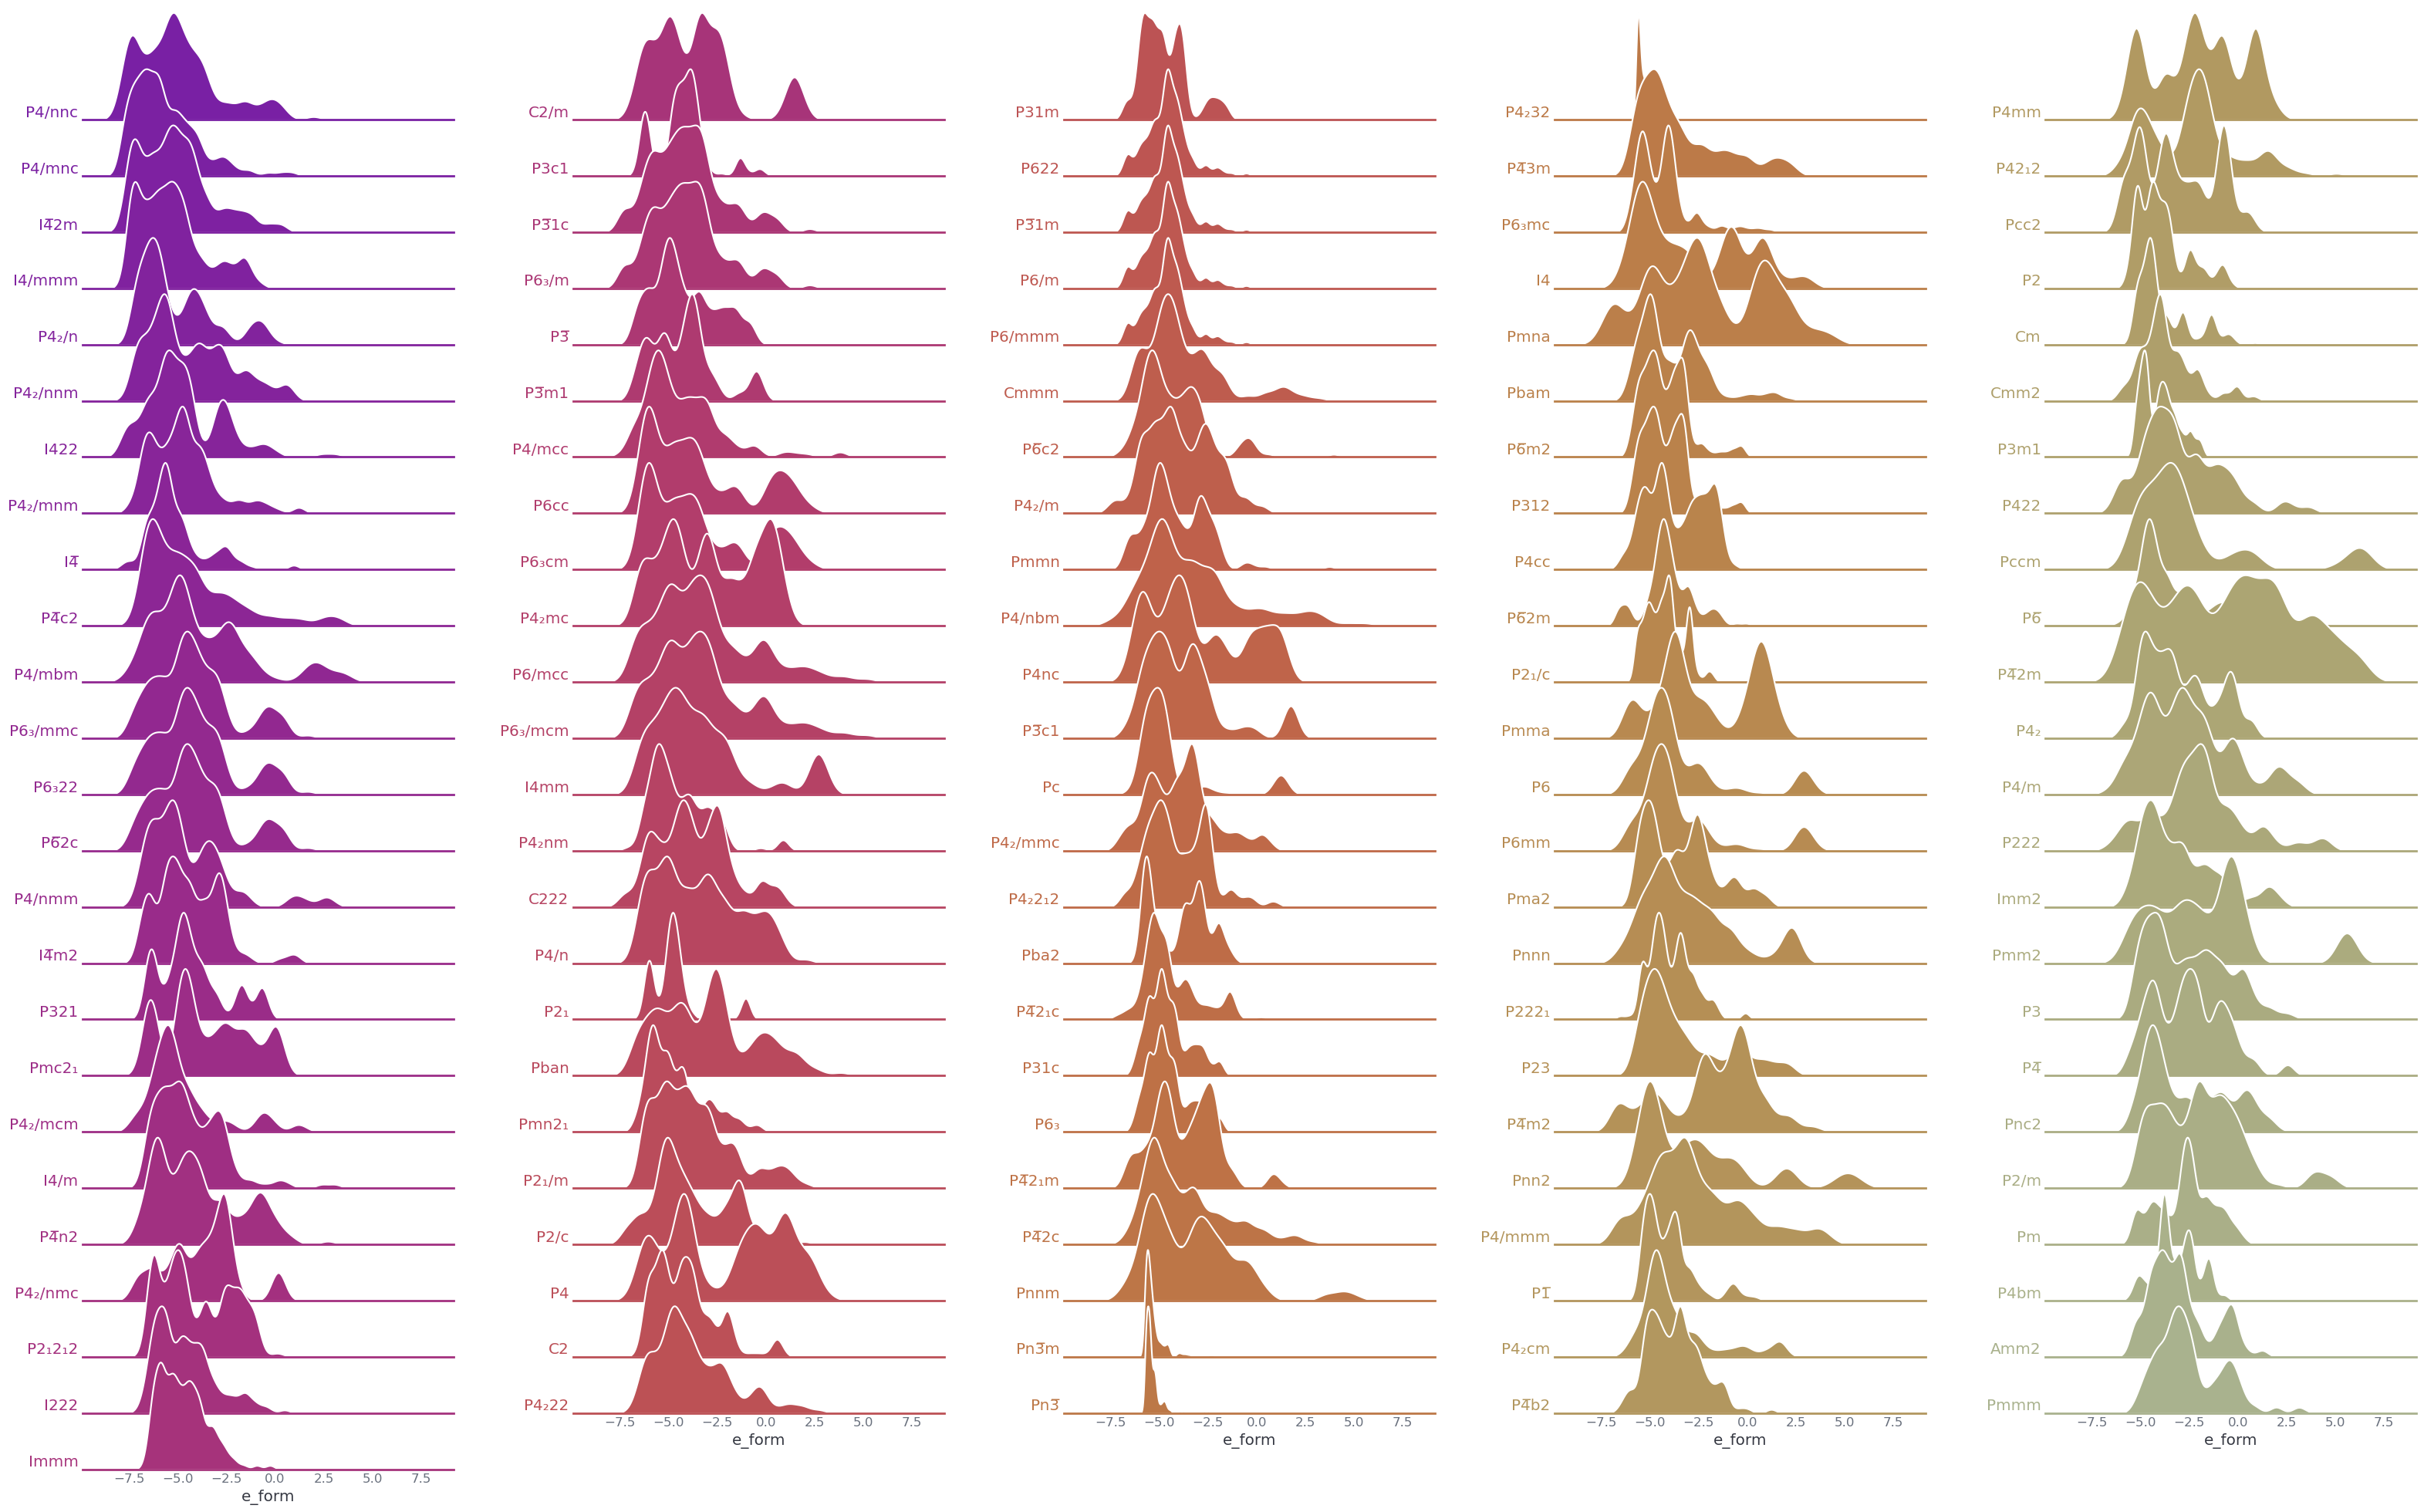

In [6]:
from baysic.viz import ridge_plot

ridge_plot(df.query('comp == "Bi2Ce4O4"'), 'group_symbol', 'e_form')

In [68]:
import torch
import pyro
import pyro.nn as nn
import pyro.distributions as dist

class LatentGaussianMixture(nn.PyroModule):
    """Mixture of Gaussians that integrates out the mixture parameter."""
    def __init__(
        self,
        num_groups: int,
        latent_dim: int = 32,
        concentration = torch.ones(3) * 2):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_groups = num_groups
        self.concentration = concentration
        self.points = nn.PyroSample(
            dist.MultivariateNormal(
                torch.zeros(latent_dim),
                torch.eye(latent_dim)
            ).expand([self.num_groups, *concentration.shape]))
        self.weights = nn.PyroSample(
            dist.Dirichlet(concentration).expand([self.num_groups])
        )


    def forward(self):
        return (self.weights, self.points)

mix = LatentGaussianMixture(2, latent_dim=6)

w, mu = mix()
print(w)
print(mu)

tensor([[0.3369, 0.1921, 0.4710],
        [0.4954, 0.4288, 0.0758]])
tensor([[[-1.3688,  0.4612, -0.1397,  1.5517, -1.2047,  0.2480],
         [-2.1840,  0.6934, -0.7565, -0.8114,  0.6521,  1.1403],
         [-0.0386, -0.1037,  1.6449,  0.1463,  0.4862,  0.1926]],

        [[ 1.1217,  0.7395, -0.0061,  1.1916,  0.0239,  0.0490],
         [-0.9586,  0.0904,  1.7341, -0.9897, -0.1377, -1.4436],
         [-0.2481, -2.6475,  0.6813,  2.4058,  0.7762,  0.3275]]])


In [82]:
def make_Xy(df):
    X = torch.tensor(np.hstack([
        df[['comp']].rank(method='dense').astype(int),
        df[['group_num']].rank(method='dense').astype(int),
    ])).long()
    y = torch.tensor(df[['e_form']].values).float()

    return (X, y)

test_comps = sorted([
    'La2Pm6', 'La2Tb6', 'Pb8Rh4', 'La10Pb6Zn2'
])
X, y = make_Xy(df.query('comp in @test_comps'))
print(len(set(X[:, 0].cpu().numpy())), 'comps')
print(len(set(X[:, 1].cpu().numpy())), 'groups')
print(X[::10000])
X.shape, y.shape

4 comps
192 groups
tensor([[  3, 121],
        [  3,  81],
        [  3, 132],
        [  4,  91],
        [  4, 190],
        [  2,  68],
        [  2, 192],
        [  1,  68],
        [  1, 120]])


(torch.Size([85533, 2]), torch.Size([85533, 1]))

In [86]:
class LatentClusterModel(nn.PyroModule):
    """Models groups as latent Gaussian mixtures."""
    def __init__(
        self,
        num_compositions: int,
        num_groups: int,
        latent_dim: int = 32,
        concentration = torch.ones(3) * 2):
        super().__init__()
        self.num_compositions = num_compositions
        self.num_groups = num_groups
        self.latent_dim = latent_dim
        self.concentration = concentration

        self.alpha = nn.PyroSample(dist.Gamma(2, 2))
        self.group_latents = LatentGaussianMixture(
            self.num_groups,
            self.latent_dim,
            self.concentration)

        # self.comp_latents = nn.PyroSample(
        #     dist.MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim)).expand([num_compositions]))

    def forward(self):
        comp_latents = self.comp_latents
        group_w, group_mu = self.group_latents()

        return (comp_latents, group_w, group_mu)

mod = LatentClusterModel(4, 6)
comp_pts, group_w, group_mu = mod()
print(comp_pts.shape, group_w.shape, group_mu.shape)

torch.Size([4, 32]) torch.Size([6, 3]) torch.Size([6, 3, 32])


In [79]:
import gpytorch

class BiModel(gpytorch.models.PyroGP):
    def __init__(
        self,
        X: torch.LongTensor,
        y: torch.FloatTensor,
        likelihood: gpytorch.likelihoods.Likelihood):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=train_y.numel(),
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution
        )

        # Standard initializtation
        super(PVGPRegressionModel, self).__init__(
            variational_strategy,
            likelihood,
            num_data=train_y.numel(),
            name_prefix=""
        )
        self.likelihood = likelihood

        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        self.num_compositions, self.num_groups = X.max(axis=0) + 1
        self.latent = LatentClusterModel(self.num_compositions, self.num_groups)
        self.cluster_i = nn.PyroSample(
            lambda self: dist.Categorical(torch.ones(3)))

    def forward(self, X):
        X_comps, X_groups = X[:, 0], X[:, 1]
        comp_mu, group_w, group_mu = self.latent()
        with pyro.plate('data', X.shape[0]):
            cluster_i = self.cluster_i

        data_group_pts = group_mu[X_groups, cluster_i]
        data_comp_pts = comp_pts[X_comps]

        mu = self.mean_module(x)
        sigma = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mu, sigma)

In [ ]:
y_scaled = (y - y.mean()) / y.std()